# 1 Pipeline Structure的结构

我们可以将典型的 TensorFlow 训练输入流水线视为 ETL 流程：

1. Extract:从永久性存储（可以是 HDD 或 SSD 等本地存储或 GCS 或 HDFS 等远程存储）读取数据。
2. Transform:使用CPU核心解析数据并对其执行预处理操作，例如图像解压缩、数据增强转换（例如随机裁剪、翻转和颜色失真）、重排和批处理。
3. Load:将转换后的数据加载到执行机器学习模型的加速器设备（例如，GPU 或 TPU）上。

# 2 tf.data.dataset API说明

tf.data API 围绕可组合转换而设计，旨在为用户提供灵活性。虽然这些转换中有很多都是可以交替的，但某些转换的顺序会对性能产生影响。

## 1 map映射和batch批次
调用传递给 map 转换的用户定义函数具有与调度和执行用户定义函数相关的开销。通常，与函数执行的计算量相比，这种开销很小。但是，如果 map 几乎不起作用，那么这种开销可能会占总成本的很大一部分。在这种情况下，建议向量化用户定义的函数（即，让该函数一次对一批输入进行操作），并在 map 转换之前先应用 batch 转换。

## 2 map映射和cache缓存

tf.data.Dataset.cache 转换可以在内存或本地存储中缓存数据集。如果传递给 map 转换的用户定义函数代价很高，则只要内存或本地存储仍可以容纳生成的数据集，就可以在映射转换后应用缓存转换。如果用户定义的函数会增加存储数据集所需的空间，并超出缓存容量，请考虑在训练作业之前预处理数据以减少资源消耗量。

## 3 map映射和interleave交错/prefetch预取/shuffle重排
许多转换（包括map interleave、prefetch 和 shuffle）都维持一个内部元素缓冲区。如果传递给 map 转换的用户定义函数改变了元素的大小，那么映射转换的顺序和缓冲元素的转换会影响内存使用量。通常，我们建议选择可以减少内存占用的顺序，除非为了提高性能而需要采用不同的顺序（例如，为了混合映射和批次转换）。

## 4 repeat重复和shuffle重排
tf.data.Dataset.repeat 转换会将输入数据重复有限（或无限）次；每次数据重复通常称为一个周期。tf.data.Dataset.shuffle 转换会随机化数据集样本的顺序。

如果在 shuffle 转换之前应用 repeat 转换，则系统会对周期边界进行模糊处理。也就是说，某些元素可以在其他元素出现之前重复出现。另一方面，如果在重复转换之前应用 shuffle 转换，那么在每个周期开始时性能可能会降低，因为需要初始化 shuffle 转换的内部状态。换言之，前者（repeat 在 shuffle 之前）可提供更好的性能，而后者（repeat 在 shuffle 之前）可提供更强的排序保证。

如果可能，建议您使用 tf.contrib.data.shuffle_and_repeat 混合转换，这样可以达到两全其美的效果（良好的性能和强大的排序保证）。否则，我们建议在repeat重复之前进行shuffle重排。

# 3 tf.data.dataset API 实例

### .map
使用map可以对数据进行预测，和python自带原理一样
```
def prepare_mnist_fea(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32)
    return x, y

ds.map(prepare_mnist_fea)
```

### .shuffle#
打乱顺序
```
ds.shuffle(10000)
```

### .batch#
使用某个batch进行迭代

```
ds.batch(32)
```

### .repeat#
重复执行整个数据多少次，也就是epoch的意思
```
ds.repeat(10)
```

# 4 tf.data加载csv

## 加载数据的方式（csv）
### 从内存中加载数据
* 例如使用numpy.load()或者pandas.read_csv()将数据加载到内存中。然后使用tf.data.dataset方法将数据加载到tensorflow中。_
```
tf.data.Dataset.from_tensors() 
tf.data.Dataset.from_tensor_slices()
```
### 从生成器中读取数据
```
ds_counter = tf.data.Dataset.from_generator(python_generator, args=[25], output_types=tf.int32, output_shapes = (), )
```
### 直接读取csv数据
```
tf.data.experimental.make_csv_dataset()
```
### 从文件中加载数据
```
tf.data.TFRecordDataset()  
tf.data.TextLineDataset()
tf.data.FixedLengthRecordDataset
```
### 从generator中加载数据
当有多个文件的时候，可以使用pandas生成读取文件的生成器。然后通过from_generator逐步加载数据。
```
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )
```
## 数据流水线的多层含义

1. 加载数据处理过程形成的流水线。（处理过程的流水线）
2. 多个文件，按顺序加载形成的流水线。（多个文件的流水线）

##  加载多个大CSV的方案

### 1 使用generator生成器。利用pandas或者numpy的方式生成数据。
### 2 使用record格式。利用TensorFlow对数据预处理，存成record格式。
### 3 使用text格式。利用TensorFlow直接读取多个csv文件，逐行进行分割。

# 5 tf.data.dataset常用方法说明

In [1]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(([8, 3, 0, 1],[1,2,1,2]))

In [12]:

# 当做可迭代对象
for elem,lebel in dataset:
  print(elem.numpy())

8
3
0
1


In [13]:
# 使用reduce对数据内容进行合并
print(dataset.reduce(0, lambda state, value: state + value).numpy())

[12  6]


In [15]:
# dataset对象可以包含各种数据结构。包括TensorFlow提供的tf.Tensor，tf.sparse.SparseTensor， tf.RaggedTensor，tf.TensorArray，或tf.data.Dataset。和Python原生的数据结构tuple，dict，NamedTuple

print(dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


# 6 tf.data.dataset常用方法实例

## Dataset.repeat()使用

In [4]:
import tensorflow as tf 
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [6]:
import matplotlib.pyplot as plt 
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

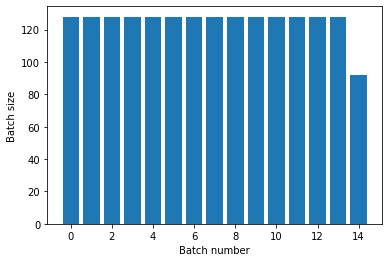

In [7]:
# 应用Dataset.repeat()不带参数的转换将无限期地重复输入。

# 该Dataset.repeat转换会将其参数没有信号一个时代的结束和下一个时代的开始。因此，Dataset.batch应用后将Dataset.repeat产生跨越历元边界的批处理：
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

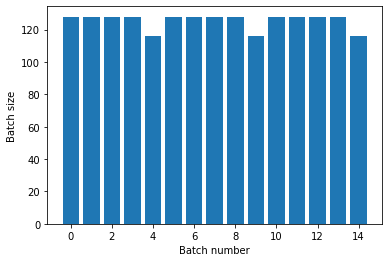

In [8]:
# 如果您需要清晰的时间间隔，请Dataset.batch在重复之前：

titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [ ]:
# 如果您想在每个时期结束时执行自定义计算（例如收集统计信息），那么最简单的方法是在每个时期重新开始数据集迭代：
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

## Dataset.shuffle()

In [9]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

In [10]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 89  94  70  48  66  32  43  57 104  81 107  61  13  26  63  39  99   6
  80   1]


In [11]:
# Dataset.shuffle直到shuffle缓冲区为空，才通知信号一个纪元的结束。因此，在重复执行之前进行随机播放会显示一个历元的每个元素，然后再移至下一个：

dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[580 603 315 577 590 515 564 625 472 526]
[594 543 532 595 614 537 530 531 388 607]
[557 411 456 519 612 490 615 476]
[20 58 88 90 69 28 15 60 57 21]
[ 18 103  30  67  26  36  56   2 112  25]


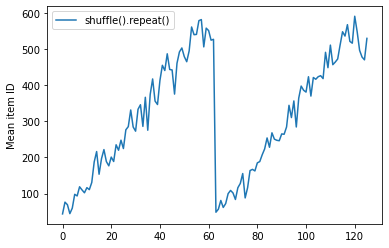

In [12]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

## Dataset.map(f)

In [13]:
# 该Dataset.map(f)变换通过施加一个给定的函数产生一个新的数据集f的输入数据集的每个元素。它基于 map()函数式编程语言中通常应用于列表（和其他结构）的功能。该函数f接受tf.Tensor表示输入中单个元素的tf.Tensor对象，并返回将表示新数据集中单个元素的对象。它的实现使用标准的TensorFlow操作将一个元素转换为另一个元素。

In [14]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

NameError: name 'flowers_root' is not defined

In [15]:
# 编写一个操作数据集元素的函数。
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

In [16]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

NameError: name 'list_ds' is not defined